In [9]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
import folium
import folium.plugins
from shapely.geometry import Point
import cartopy.crs as ccrs 



In [10]:
def year_day_to_datetime(year, day_of_year):
  """Converts a year and day of year to a datetime object.

  Args:
    year: The year (e.g., 2023).
    day_of_year: The day of the year (1-365 or 1-366 for leap years).

  Returns:
    A datetime object representing the given year and day of year.
  """
  try:
    datetime_object = datetime.datetime.strptime(f'{year}-{day_of_year}', '%Y-%j')
    return datetime_object
  except ValueError:
    print(f"Invalid date: {year}-{day_of_year}")
    return None  # Handle cases with invalid day of year
  


In [11]:
### Load the data form a csv
df = pd.read_csv('../../Data/Firegrowth_groups_v1_01.csv')
df.columns

#drop all columns but latitude, longitude, cumulative area, and fire name, year and DOB
df = df[['lon', 'lat', 'ID', 'year', 'DOB', 'cumuarea']]

#remove all rows with NaN values
df = df.dropna()

df = df.drop_duplicates(subset=['ID'], keep='last')

df['datetime'] = df.apply(lambda row: year_day_to_datetime(row['year'], row['DOB']), axis=1)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d', errors='coerce')

#make it a geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.crs = 'EPSG:4326'

gdf.head()


,lon,lat,ID,year,DOB,cumuarea,datetime,geometry
4,-116.459958,56.777929,2002_109,2002,179,9833.40,2002-06-28,POINT (-116.45996 56.77793)
11,-128.739971,60.834966,2002_11,2002,173,6097.68,2002-06-22,POINT (-128.73997 60.83497)
14,-114.745446,57.049854,2002_116,2002,178,8505.00,2002-06-27,POINT (-114.74545 57.04985)
31,-115.065407,56.768829,2002_130,2002,191,3943.08,2002-07-10,POINT (-115.06541 56.76883)
32,-109.603870,57.584611,2002_131,2002,194,1584.36,2002-07-13,POINT (-109.60387 57.58461)


Original GeoDataFrame snippet:
           lon        lat        ID  year  DOB  cumuarea   datetime  \
4  -116.459958  56.777929  2002_109  2002  179   9833.40 2002-06-28   
11 -128.739971  60.834966   2002_11  2002  173   6097.68 2002-06-22   
14 -114.745446  57.049854  2002_116  2002  178   8505.00 2002-06-27   
31 -115.065407  56.768829  2002_130  2002  191   3943.08 2002-07-10   
32 -109.603870  57.584611  2002_131  2002  194   1584.36 2002-07-13   

                       geometry  grid_lon_corner  grid_lat_corner  \
4   POINT (-116.45996 56.77793)           -120.0             55.0   
11  POINT (-128.73997 60.83497)           -130.0             60.0   
14  POINT (-114.74545 57.04985)           -115.0             55.0   
31  POINT (-115.06541 56.76883)           -120.0             55.0   
32  POINT (-109.60387 57.58461)           -110.0             55.0   

    centroid_lon  centroid_lat  month  
4         -117.5          57.5      6  
11        -127.5          62.5      6  
14     

/tmp/ipykernel_19016/3757891999.py:116: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_aggregated_df['cumuarea'].fillna(0, inplace=True)



Final Aggregated Grid GeoDataFrame snippet (includes zeros):
   centroid_lon  centroid_lat  year  month  cumuarea             geometry
0        -142.5          47.5  2002      1       0.0  POINT (-142.5 47.5)
1        -142.5          47.5  2002      2       0.0  POINT (-142.5 47.5)
2        -142.5          47.5  2002      3       0.0  POINT (-142.5 47.5)
3        -142.5          47.5  2002      4       0.0  POINT (-142.5 47.5)
4        -142.5          47.5  2002      5       0.0  POINT (-142.5 47.5)

Final Grid CRS: EPSG:4326
Total rows in final GeoDataFrame: 21600


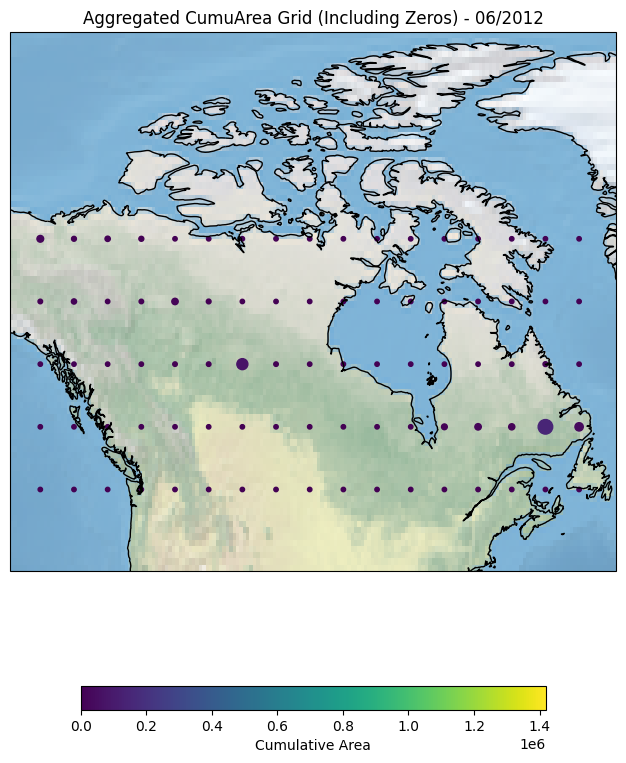


Script finished. Final GeoDataFrame includes zero-area grid cells.


In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from itertools import product # Needed for creating combinations

# --- Assume 'gdf' is your loaded GeoDataFrame ---
# Example placeholder if you don't have gdf loaded:
# data = {
#     'datetime': pd.to_datetime(['2002-01-15', '2002-01-20', '2002-02-10', '2003-05-05', '2002-01-18']),
#     'cumuarea': [10.5, 5.2, 8.0, 15.1, 3.0],
#     'geometry': [Point(-100.1, 60.1), Point(-100.2, 60.15), Point(-110.3, 70.3), Point(-95.8, 55.8), Point(-100.15, 60.12)] # Example points
# }
# gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")
# gdf['year'] = gdf['datetime'].dt.year # Add year column if not present


# --- Ensure Necessary Columns Exist ---
if 'datetime' not in gdf.columns or not pd.api.types.is_datetime64_any_dtype(gdf['datetime']):
     raise ValueError("GeoDataFrame must have a 'datetime' column of datetime objects.")
if 'cumuarea' not in gdf.columns:
     raise ValueError("GeoDataFrame must have a 'cumuarea' column.")
if 'geometry' not in gdf.columns:
     raise ValueError("GeoDataFrame must have a 'geometry' column.")

# Add year column if it doesn't exist
if 'year' not in gdf.columns:
    gdf['year'] = gdf['datetime'].dt.year

print("Original GeoDataFrame snippet:")
print(gdf.head())
print(f"\nOriginal CRS: {gdf.crs}")

#*** --- 1. Define Grid Resolution and Calculate Centroid Offset --- ***
grid_res = 5
centroid_offset = grid_res / 2.0  # 0.125

# --- 2. Calculate Target Grid Centroid for Each *Existing* Point ---
# Calculate the bottom-left corner of the grid cell each point falls into
gdf['grid_lon_corner'] = np.floor(gdf.geometry.x / grid_res) * grid_res
gdf['grid_lat_corner'] = np.floor(gdf.geometry.y / grid_res) * grid_res

# Calculate the centroid of that grid cell
gdf['centroid_lon'] = gdf['grid_lon_corner'] + centroid_offset
gdf['centroid_lat'] = gdf['grid_lat_corner'] + centroid_offset

# --- 3. Extract Temporal Information for *Existing* Points ---
gdf['month'] = gdf['datetime'].dt.month

# --- 4. Group and Aggregate *Existing* Data ---
# Group by the calculated centroid coordinates, year, and month
aggregated_data_non_zero = gdf.groupby(['centroid_lon', 'centroid_lat', 'year', 'month'])['cumuarea'].sum()

# Convert the result (Pandas Series with MultiIndex) back to a DataFrame
aggregated_df_non_zero = aggregated_data_non_zero.reset_index()

print("\nAggregated data with non-zero cumuarea (DataFrame format):")
print(aggregated_df_non_zero.head())

# --- 5. Create the Complete Grid and Time Template ---

# 5a. Determine Grid Extent and Generate All Grid Centroids
minx, miny, maxx, maxy = gdf.total_bounds
# Ensure bounds align with grid resolution
minx_grid = np.floor(minx / grid_res) * grid_res
miny_grid = np.floor(miny / grid_res) * grid_res
maxx_grid = np.ceil(maxx / grid_res) * grid_res # Use ceil for max
maxy_grid = np.ceil(maxy / grid_res) * grid_res # Use ceil for max

# Generate all possible corner coordinates within the extent
grid_lon_corners = np.arange(minx_grid, maxx_grid, grid_res)
grid_lat_corners = np.arange(miny_grid, maxy_grid, grid_res)

# Calculate all possible centroid coordinates
all_centroid_lons = grid_lon_corners + centroid_offset
all_centroid_lats = grid_lat_corners + centroid_offset

# Create all combinations of centroids
all_centroids = pd.DataFrame(list(product(all_centroid_lons, all_centroid_lats)),
                             columns=['centroid_lon', 'centroid_lat'])

# 5b. Determine Time Range and Generate All Time Steps
min_year = gdf['year'].min()
max_year = gdf['year'].max()
# Consider all 12 months for each year in the range
all_years = range(min_year, max_year + 1)
all_months = range(1, 13)

# Create all combinations of year and month
all_time_steps = pd.DataFrame(list(product(all_years, all_months)),
                              columns=['year', 'month'])

# 5c. Create the Full Template DataFrame by Cross Joining Grids and Time Steps
# Add a dummy key for cross join
all_centroids['key'] = 1
all_time_steps['key'] = 1
full_template_df = pd.merge(all_centroids, all_time_steps, on='key').drop('key', axis=1)

print(f"\nCreated a full template with {len(full_template_df)} potential grid-time combinations.")
print("Full template snippet:")
print(full_template_df.head())


# --- 6. Merge Aggregated Data onto the Full Template ---
# Perform a left merge: keep all rows from the template, add 'cumuarea' where matches exist
complete_aggregated_df = pd.merge(
    full_template_df,
    aggregated_df_non_zero,
    on=['centroid_lon', 'centroid_lat', 'year', 'month'],
    how='left'
)

# --- 7. Fill Missing 'cumuarea' with 0 ---
complete_aggregated_df['cumuarea'].fillna(0, inplace=True)

print("\nComplete aggregated data (with zeros) snippet:")
print(complete_aggregated_df.head())
# Check if zeros were added (find a row that should be zero)
# print(complete_aggregated_df[(complete_aggregated_df['year'] == min_year) & (complete_aggregated_df['month'] == 1)].head())


# --- 8. Create Final Grid GeoDataFrame ---
# Create Point geometries from the centroid coordinates
geometry = [Point(xy) for xy in zip(complete_aggregated_df['centroid_lon'], complete_aggregated_df['centroid_lat'])]

# Create the final GeoDataFrame using the original CRS
grid_gdf = gpd.GeoDataFrame(complete_aggregated_df, geometry=geometry, crs=gdf.crs)

# Optional: Drop intermediate columns if desired (keep centroids for now)
# grid_gdf = grid_gdf.drop(columns=['centroid_lon', 'centroid_lat'])

print("\nFinal Aggregated Grid GeoDataFrame snippet (includes zeros):")
print(grid_gdf.head())
print(f"\nFinal Grid CRS: {grid_gdf.crs}")
print(f"Total rows in final GeoDataFrame: {len(grid_gdf)}")


#* --- Optional: Visualization ---

# Filter for a specific month/year for clarity
plot_year = 2012 # Example year from original data
plot_month = 6 # Example month

# Filter the *complete* grid data
plot_data = grid_gdf[(grid_gdf['year'] == plot_year) & (grid_gdf['month'] == plot_month)]

# Filter out cells with zero area for *plotting* if desired (makes plot less dense)
# plot_data_non_zero = plot_data[plot_data['cumuarea'] > 0]
plot_data_non_zero = plot_data # Plot all including zeros for this example

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Use PlateCarree for lon/lat
ax.stock_img() # Add background continents/oceans
ax.coastlines()

if not plot_data_non_zero.empty:
    # Calculate marker sizes (handle case where max area is 0)
    max_area = plot_data_non_zero['cumuarea'].max()
    if max_area > 0:
         marker_sizes = (plot_data_non_zero['cumuarea'] / max_area) * 100 + 10 # Scale non-zero areas
    else:
         marker_sizes = 10 # Fixed small size if all areas are 0

    # Plot grid centroids, size/color by cumuarea
    # Use vmin/vmax in plot for consistent color scale even if filtered data has limited range
    plot = plot_data_non_zero.plot(
        ax=ax,
        marker='o',
        column='cumuarea',
        cmap='viridis',
        markersize=marker_sizes,
        legend=True,
        transform=ccrs.Geodetic(), # Specify transform for plotting lon/lat data
        legend_kwds={'label': "Cumulative Area", 'orientation': "horizontal", 'shrink': 0.5},
        vmin=0, # Set minimum for color scale
        vmax=grid_gdf['cumuarea'].max() # Use max from *all* data for consistent scale
     )
    # Plot points with zero area as small grey dots if desired
    # plot_data_zero = plot_data[plot_data['cumuarea'] == 0]
    # if not plot_data_zero.empty:
    #     plot_data_zero.plot(ax=ax, marker='.', color='grey', markersize=5, transform=ccrs.Geodetic())

    ax.set_extent([-142, -52, 41, 84], crs=ccrs.PlateCarree()) # Approximate Canada extent
    ax.set_title(f"Aggregated CumuArea Grid (Including Zeros) - {plot_month:02d}/{plot_year}")

else:
    print(f"\nNo grid data found for {plot_month:02d}/{plot_year} (this shouldn't happen with the new method).")
    ax.set_extent([-142, -52, 41, 84], crs=ccrs.PlateCarree())
    ax.set_title(f"Aggregated CumuArea Grid - No Data for {plot_month:02d}/{plot_year}")

plt.show()

# --- Optional: Save to file ---
# Make sure the directory exists before saving
import os
output_dir = "../../Data"
os.makedirs(output_dir, exist_ok=True)

# Consider saving smaller chunks if the full dataset is very large
grid_gdf.to_file(os.path.join(output_dir, "aggregated_wildfire_grid_complete_1deg_w0.gpkg"), driver="GPKG")
grid_gdf.to_csv(os.path.join(output_dir, "aggregated_wildfire_grid_complete_1deg_w0.csv"), index=False)


print("\nScript finished. Final GeoDataFrame includes zero-area grid cells.")